In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmaps of AUC

In [13]:
data = pd.read_csv("../data/interim/valid_results_fixed.csv")
data

,training_set,valid_set,class,fold,auc
0,NormalDataset,Normal,GLAUCOMA SUSPECT,0,0.709184
1,NormalDataset,Normal,GLAUCOMA SUSPECT,1,0.630268
2,NormalDataset,Normal,GLAUCOMA SUSPECT,2,0.715624
3,NormalDataset,Normal,GLAUCOMA SUSPECT,3,0.755542
4,NormalDataset,Normal,GLAUCOMA SUSPECT,4,0.661345
...,...,...,...,...,...
120,OnlyDiscBB_0,OnlyDiscBB,GLAUCOMA SUSPECT,0,0.738163
121,OnlyDiscBB_0,OnlyDiscBB,GLAUCOMA SUSPECT,1,0.783312
122,OnlyDiscBB_0,OnlyDiscBB,GLAUCOMA SUSPECT,2,0.809281
123,OnlyDiscBB_0,OnlyDiscBB,GLAUCOMA SUSPECT,3,0.660714


In [14]:
data.groupby(["class","training_set","valid_set"])["auc"].mean()
#data.groupby(["class","training_set","valid_set"])["auc"].mean()[["NoDiscDataset_0","NoDiscBB_0","NormalDataset","OnlyDisc_0","OnlyDiscBB_0"]]

class             training_set     valid_set 
GLAUCOMA SUSPECT  NoDiscBB_0       NoDisc        0.511257
                                   NoDiscBB      0.529811
                                   Normal        0.517494
                                   OnlyDisc      0.500445
                                   OnlyDiscBB    0.466788
                  NoDiscDataset_0  NoDisc        0.602889
                                   NoDiscBB      0.523207
                                   Normal        0.524690
                                   OnlyDisc      0.561654
                                   OnlyDiscBB    0.503696
                  NormalDataset    NoDisc        0.542999
                                   NoDiscBB      0.518839
                                   Normal        0.694393
                                   OnlyDisc      0.745710
                                   OnlyDiscBB    0.677208
                  OnlyDiscBB_0     NoDisc        0.550440
                          

In [15]:
mean_auc_per_class = data.groupby(["class","training_set","valid_set"])["auc"].mean()

In [16]:
mean_auc_per_class.index

MultiIndex([('GLAUCOMA SUSPECT',      'NoDiscBB_0',     'NoDisc'),
            ('GLAUCOMA SUSPECT',      'NoDiscBB_0',   'NoDiscBB'),
            ('GLAUCOMA SUSPECT',      'NoDiscBB_0',     'Normal'),
            ('GLAUCOMA SUSPECT',      'NoDiscBB_0',   'OnlyDisc'),
            ('GLAUCOMA SUSPECT',      'NoDiscBB_0', 'OnlyDiscBB'),
            ('GLAUCOMA SUSPECT', 'NoDiscDataset_0',     'NoDisc'),
            ('GLAUCOMA SUSPECT', 'NoDiscDataset_0',   'NoDiscBB'),
            ('GLAUCOMA SUSPECT', 'NoDiscDataset_0',     'Normal'),
            ('GLAUCOMA SUSPECT', 'NoDiscDataset_0',   'OnlyDisc'),
            ('GLAUCOMA SUSPECT', 'NoDiscDataset_0', 'OnlyDiscBB'),
            ('GLAUCOMA SUSPECT',   'NormalDataset',     'NoDisc'),
            ('GLAUCOMA SUSPECT',   'NormalDataset',   'NoDiscBB'),
            ('GLAUCOMA SUSPECT',   'NormalDataset',     'Normal'),
            ('GLAUCOMA SUSPECT',   'NormalDataset',   'OnlyDisc'),
            ('GLAUCOMA SUSPECT',   'NormalDataset', 'OnlyDiscB

In [17]:
mean_auc_per_class[mean_auc_per_class.index.get_level_values('class')]

class             training_set  valid_set 
GLAUCOMA SUSPECT  NoDiscBB_0    NoDisc        0.511257
                                NoDiscBB      0.529811
                                Normal        0.517494
                                OnlyDisc      0.500445
                                OnlyDiscBB    0.466788
                                                ...   
                  OnlyDisc_0    NoDisc        0.515718
                                NoDiscBB      0.494327
                                Normal        0.518522
                                OnlyDisc      0.825062
                                OnlyDiscBB    0.748689
Name: auc, Length: 625, dtype: float64

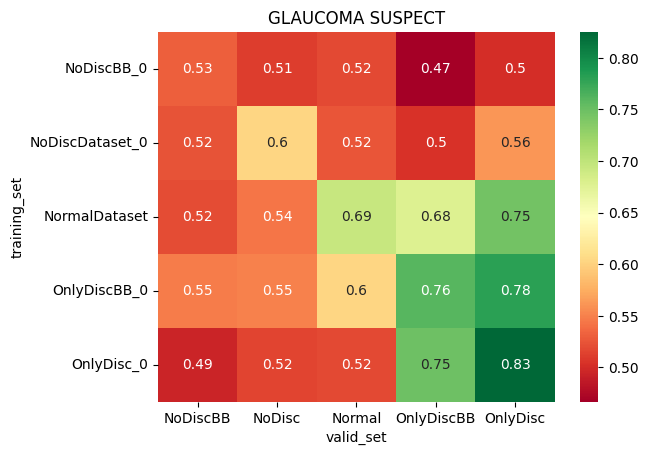

In [18]:
for class_label in mean_auc_per_class.index.get_level_values('class').unique():
    result_class = mean_auc_per_class[mean_auc_per_class.index.get_level_values('class').isin([class_label])].droplevel(0)
    result_class = result_class.reset_index().pivot(columns='valid_set',index='training_set',values='auc')
    result_class = result_class[["NoDiscBB","NoDisc","Normal","OnlyDiscBB","OnlyDisc"]]
    plt.figure()
    plt.title(class_label)
    sns.heatmap(result_class, annot=True,cmap="RdYlGn")
    plt.show()

# Test set

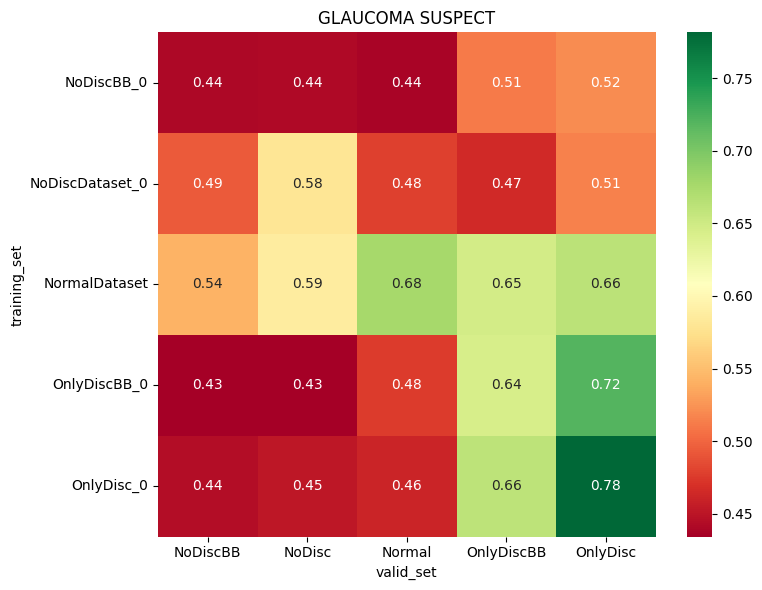

In [3]:
data = pd.read_csv("../data/interim/test_results.csv")
mean_auc_per_class = data.groupby(["class","training_set","valid_set"])["auc"].mean()
for class_label in mean_auc_per_class.index.get_level_values('class').unique():
    result_class = mean_auc_per_class[mean_auc_per_class.index.get_level_values('class').isin([class_label])].droplevel(0)
    result_class = result_class.reset_index().pivot(columns='valid_set',index='training_set',values='auc')
    result_class = result_class[["NoDiscBB","NoDisc","Normal","OnlyDiscBB","OnlyDisc"]]
    plt.figure(figsize=(8,6))
    plt.title(class_label)
    sns.heatmap(result_class, annot=True,cmap="RdYlGn")
    plt.tight_layout()
    plt.savefig(f"../reports/figures/test_mean_auc_{class_label}.png",format='png')
    plt.show()

## Impact of dilation

On healthy image probability


 NoDiscDataset_0 0

 NoDiscDataset_0 5

 NoDiscDataset_0 10

 NoDiscDataset_0 25

 NoDiscDataset_0 50

 NoDiscDataset_0 100

 NoDiscDataset_0 200

 NoDiscDataset_0 300

 NoDiscDataset_0 400

 NoDiscDataset_0 500


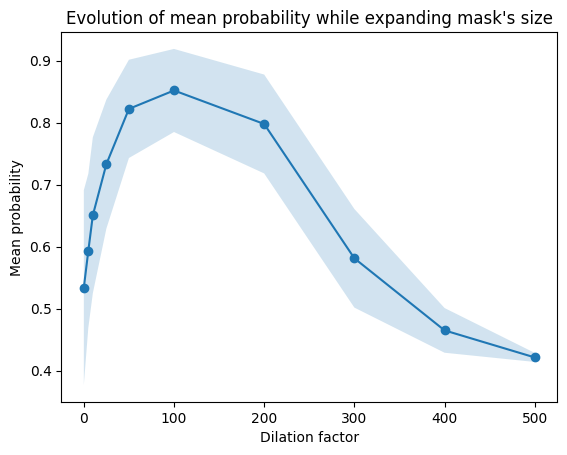

In [53]:
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import os.path

import torch
import torch.optim as optim
from torchvision.models import resnet50,densenet121
from torchvision.transforms import v2
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score, roc_curve


from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset
import pandas as pd
from sklearn.metrics import RocCurveDisplay

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_mean_std_proba(model,valid_dataloader,dilation):
    model.to(DEVICE)
    model.eval()
    lst_labels = []
    lst_preds = []
    lst_probas = []
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            inputs, labels = data
            if sum(labels) == 0:
                continue
            inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
            outputs = model(inputs)
            output_sigmoid = sigmoid(outputs)
            lst_labels.extend(labels.cpu().detach().numpy())
            lst_probas.extend(output_sigmoid.cpu().detach().numpy())
            lst_preds.extend(output_sigmoid.cpu().detach().numpy()>0.5)
        
        lst_labels = np.array(lst_labels)
        lst_preds = np.array(lst_preds)
        lst_probas = np.array(lst_probas)
        dict_val = {"labels":lst_labels[:,0],"probas":lst_probas[:,0],"preds":lst_preds[:,0]}
        df = pd.DataFrame(dict_val).sort_values(by=['probas'])
        df.to_csv(f"./preds_glaucoma_{dilation}.csv")

    return np.mean(lst_probas),np.std(lst_probas)

def main():
    #Get hyperparameters 
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = 1
    CLASSES = os.environ.get("CLASSES").split(",")
    model_name= "NoDiscDataset_0"
        
    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed/Train")
    testing_data = MaskingDataset(data_dir="../data/processed/Test")
    
    y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]

    #Create k-fold for train/val
    stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)

    lst_dilation = [0,5,10,25,50,100,200,300,400,500]
    mean_probas = []
    std_probas = []
    for dilation_factor in lst_dilation:
        print("\n",model_name,dilation_factor)
        params={"masking_spread":dilation_factor,"inverse_roi":False,"bounding_box":False}
        for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
            val_data = MaskingDataset(data_dir="../data/processed/Train",**params)
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
            
            
            #Define model, loss and optimizer
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )
            
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            mean,std = get_mean_std_proba(model,valid_dataloader,dilation_factor)
            mean_probas.append(mean)
            std_probas.append(std)
            break
    
    lst_dilation = np.array(lst_dilation)
    mean_probas = np.array(mean_probas)
    std_probas = np.array(std_probas)
    plt.figure()
    plt.plot(lst_dilation,mean_probas,marker="o")
    plt.fill_between(lst_dilation, mean_probas-std_probas, mean_probas+std_probas,alpha=0.2)
    plt.title("Evolution of mean probability while expanding mask's size")
    plt.xlabel("Dilation factor")
    plt.ylabel("Mean probability")
    # plt.savefig("../reports/figures/mean_proba_dilation.png")
    plt.show()
if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()


On AUC


Healthy images 0

Healthy images 5

Healthy images 10

Healthy images 25

Healthy images 50

Healthy images 100

Healthy images 150

Healthy images 200

Healthy images 300

Healthy images 400

Healthy images 500

Glaucoma images 0

Glaucoma images 5

Glaucoma images 10

Glaucoma images 25

Glaucoma images 50

Glaucoma images 100

Glaucoma images 150

Glaucoma images 200

Glaucoma images 300

Glaucoma images 400

Glaucoma images 500


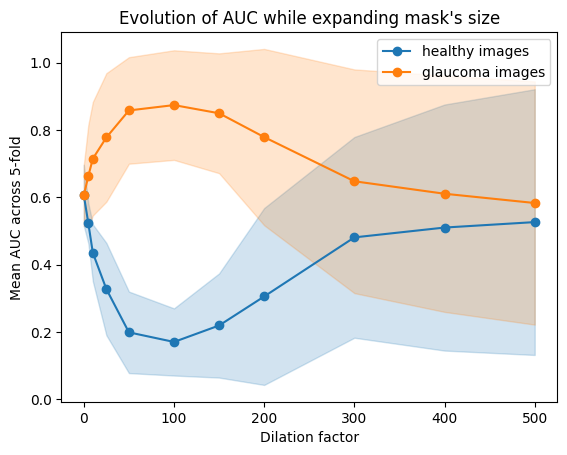

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.models import resnet50,densenet121
from torchvision.transforms import v2
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score


from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset
import pandas as pd
import copy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NB_FOLDS = 5
BATCH_SIZE = 1
CLASSES = ["GLAUCOMA SUSPECT"]
model_name= "NoDiscDataset_0"

#Define model
model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k

# Freeze every layer except last denseblock and classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.features.denseblock4.denselayer16.parameters():
    param.requires_grad = True

kernel_count = model.classifier.in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(kernel_count, len(CLASSES))
)

#Load the base dataset
training_data = MaskingDataset(data_dir="../data/processed/Train")
testing_data = MaskingDataset(data_dir="../data/processed/Test")

y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]

#Create k-fold for train/val
stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)

lst_dilation = [0,5,10,25,50,100,150,200,300,400,500]
lst_auc_healthy_dilation = [[] for i in range(len(lst_dilation))]
lst_auc_glaucoma_dilation = [[] for i in range(len(lst_dilation))]

#First for healthy
for k,dilation_factor in enumerate(lst_dilation):
    print("\nHealthy images",dilation_factor)
    params={"masking_spread":dilation_factor,"inverse_roi":False,"bounding_box":False}
    for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
        
        val_data = MaskingDataset(data_dir="../data/processed/Train",**params)
        val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
        val_data.img_paths = np.array(training_data.img_paths)[val_index]
        val_data.roi_paths = np.array(training_data.roi_paths)[val_index]
        valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

        try:
            model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
            model.to(DEVICE)
            model.eval()
        except FileNotFoundError as e:
            print("No model saved for fold",i)
            continue
    
        lst_labels = []
        lst_probas = []
        auc_scores = []
        valid_dataloader_normal = copy.deepcopy(valid_dataloader)
        valid_dataloader_normal.dataset.masking_spread = 0

        with torch.no_grad():
            for i,data in enumerate(zip(valid_dataloader,valid_dataloader_normal)):
                if sum(data[0][1]) == 0:
                    inputs,labels = data[0]
                else:
                    inputs,labels = data[1]
                
                inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                outputs = model(inputs)
                output_sigmoid = sigmoid(outputs)
                lst_labels.extend(labels.cpu().detach().numpy())
                lst_probas.extend(output_sigmoid.cpu().detach().numpy())
            
            lst_labels = np.array(lst_labels)
            lst_probas = np.array(lst_probas)
            for i in range(lst_labels.shape[1]):
                labels = lst_labels[:,i]
                probas = lst_probas[:,i]
                auc_score=roc_auc_score(labels,probas)
                auc_scores.append(auc_score)
            
            auc = auc_scores[0]
            lst_auc_healthy_dilation[k].append(auc)

#Than for glaucoma images
for k,dilation_factor in enumerate(lst_dilation):
    print("\nGlaucoma images",dilation_factor)
    params={"masking_spread":dilation_factor,"inverse_roi":False,"bounding_box":False}
    for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
        
        val_data = MaskingDataset(data_dir="../data/processed/Train",**params)
        val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
        val_data.img_paths = np.array(training_data.img_paths)[val_index]
        val_data.roi_paths = np.array(training_data.roi_paths)[val_index]
        valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

        try:
            model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
            model.to(DEVICE)
            model.eval()
        except FileNotFoundError as e:
            print("No model saved for fold",i)
            continue
    
        lst_labels = []
        lst_probas = []
        auc_scores = []
        valid_dataloader_normal = copy.deepcopy(valid_dataloader)
        valid_dataloader_normal.dataset.masking_spread = 0

        with torch.no_grad():
            for i,data in enumerate(zip(valid_dataloader,valid_dataloader_normal)):
                if sum(data[0][1]) != 0:
                    inputs,labels = data[0]
                else:
                    inputs,labels = data[1]
                
                inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                outputs = model(inputs)
                output_sigmoid = sigmoid(outputs)
                lst_labels.extend(labels.cpu().detach().numpy())
                lst_probas.extend(output_sigmoid.cpu().detach().numpy())
            
            lst_labels = np.array(lst_labels)
            lst_probas = np.array(lst_probas)
            for i in range(lst_labels.shape[1]):
                labels = lst_labels[:,i]
                probas = lst_probas[:,i]
                auc_score=roc_auc_score(labels,probas)
                auc_scores.append(auc_score)
            
            auc = auc_scores[0]
            lst_auc_glaucoma_dilation[k].append(auc)

lst_auc_healthy_dilation = np.array(lst_auc_healthy_dilation)
lst_auc_glaucoma_dilation = np.array(lst_auc_glaucoma_dilation)

plt.figure()
mean_auc_healthy = np.array([np.mean(lst_auc_healthy_dilation[k]) for k in range(len(lst_auc_healthy_dilation))])
std_auc_healthy = np.array([np.std(lst_auc_healthy_dilation[k]) for k in range(len(lst_auc_healthy_dilation))])
plt.plot(lst_dilation,mean_auc_healthy,marker="o",label="healthy images",color="tab:blue")
plt.fill_between(lst_dilation, mean_auc_healthy-std_auc_healthy, mean_auc_healthy+std_auc_healthy,alpha=0.2,color="tab:blue")

mean_auc_glaucoma = np.array([np.mean(lst_auc_glaucoma_dilation[k]) for k in range(len(lst_auc_glaucoma_dilation))])
std_auc_glaucoma = np.array([np.std(lst_auc_glaucoma_dilation[k]) for k in range(len(lst_auc_glaucoma_dilation))])
plt.plot(lst_dilation,mean_auc_glaucoma,marker="o",label="glaucoma images",color="tab:orange")
plt.fill_between(lst_dilation, mean_auc_glaucoma-std_auc_glaucoma, mean_auc_glaucoma+std_auc_glaucoma,alpha=0.2,color="tab:orange")


plt.title("Evolution of AUC while expanding mask's size")
plt.xlabel("Dilation factor")
plt.ylabel("Mean AUC across 5-fold")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("../reports/figures/mean_auc_dilation.png")
plt.show()


Healthy images 0

Healthy images 5

Healthy images 10

Healthy images 25

Healthy images 50

Healthy images 100

Healthy images 150

Healthy images 200

Healthy images 300

Healthy images 400

Healthy images 500

Glaucoma images 0

Glaucoma images 5

Glaucoma images 10

Glaucoma images 25

Glaucoma images 50

Glaucoma images 100

Glaucoma images 150

Glaucoma images 200

Glaucoma images 300

Glaucoma images 400

Glaucoma images 500


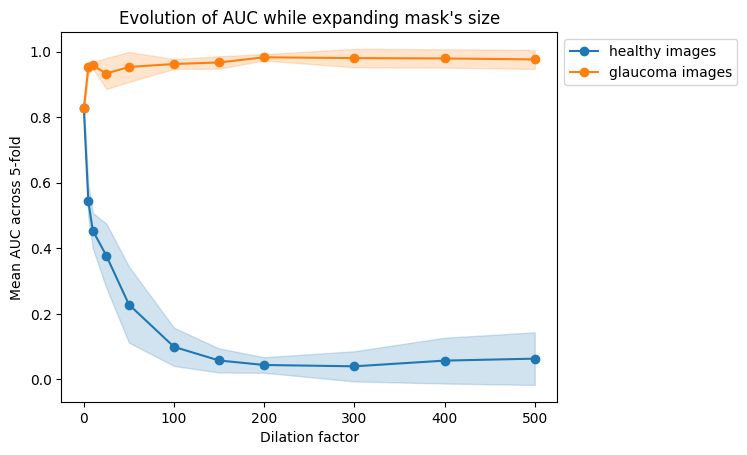

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.models import resnet50,densenet121
from torchvision.transforms import v2
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score


from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset
import pandas as pd
import copy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NB_FOLDS = 5
BATCH_SIZE = 1
CLASSES = ["GLAUCOMA SUSPECT"]
model_name= "OnlyDisc_0"

#Define model
model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k

# Freeze every layer except last denseblock and classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.features.denseblock4.denselayer16.parameters():
    param.requires_grad = True

kernel_count = model.classifier.in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(kernel_count, len(CLASSES))
)

#Load the base dataset
training_data = MaskingDataset(data_dir="../data/processed/Train")
testing_data = MaskingDataset(data_dir="../data/processed/Test")

y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]

#Create k-fold for train/val
stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)

lst_dilation = [0,5,10,25,50,100,150,200,300,400,500]
lst_auc_healthy_dilation = [[] for i in range(len(lst_dilation))]
lst_auc_glaucoma_dilation = [[] for i in range(len(lst_dilation))]

#First for healthy
for k,dilation_factor in enumerate(lst_dilation):
    print("\nHealthy images",dilation_factor)
    params={"masking_spread":dilation_factor,"inverse_roi":True,"bounding_box":False}
    for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
        
        val_data = MaskingDataset(data_dir="../data/processed/Train",**params)
        val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
        val_data.img_paths = np.array(training_data.img_paths)[val_index]
        val_data.roi_paths = np.array(training_data.roi_paths)[val_index]
        valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

        try:
            model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
            model.to(DEVICE)
            model.eval()
        except FileNotFoundError as e:
            print("No model saved for fold",i)
            continue
    
        lst_labels = []
        lst_probas = []
        auc_scores = []
        valid_dataloader_normal = copy.deepcopy(valid_dataloader)
        valid_dataloader_normal.dataset.masking_spread = 0

        with torch.no_grad():
            for i,data in enumerate(zip(valid_dataloader,valid_dataloader_normal)):
                if sum(data[0][1]) == 0:
                    inputs,labels = data[0]
                else:
                    inputs,labels = data[1]
                
                inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                outputs = model(inputs)
                output_sigmoid = sigmoid(outputs)
                lst_labels.extend(labels.cpu().detach().numpy())
                lst_probas.extend(output_sigmoid.cpu().detach().numpy())
            
            lst_labels = np.array(lst_labels)
            lst_probas = np.array(lst_probas)
            for i in range(lst_labels.shape[1]):
                labels = lst_labels[:,i]
                probas = lst_probas[:,i]
                auc_score=roc_auc_score(labels,probas)
                auc_scores.append(auc_score)
            
            auc = auc_scores[0]
            lst_auc_healthy_dilation[k].append(auc)

#Than for glaucoma images
for k,dilation_factor in enumerate(lst_dilation):
    print("\nGlaucoma images",dilation_factor)
    params={"masking_spread":dilation_factor,"inverse_roi":True,"bounding_box":False}
    for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
        
        val_data = MaskingDataset(data_dir="../data/processed/Train",**params)
        val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
        val_data.img_paths = np.array(training_data.img_paths)[val_index]
        val_data.roi_paths = np.array(training_data.roi_paths)[val_index]
        valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

        try:
            model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
            model.to(DEVICE)
            model.eval()
        except FileNotFoundError as e:
            print("No model saved for fold",i)
            continue
    
        lst_labels = []
        lst_probas = []
        auc_scores = []
        valid_dataloader_normal = copy.deepcopy(valid_dataloader)
        valid_dataloader_normal.dataset.masking_spread = 0

        with torch.no_grad():
            for i,data in enumerate(zip(valid_dataloader,valid_dataloader_normal)):
                if sum(data[0][1]) != 0:
                    inputs,labels = data[0]
                else:
                    inputs,labels = data[1]
                
                inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                outputs = model(inputs)
                output_sigmoid = sigmoid(outputs)
                lst_labels.extend(labels.cpu().detach().numpy())
                lst_probas.extend(output_sigmoid.cpu().detach().numpy())
            
            lst_labels = np.array(lst_labels)
            lst_probas = np.array(lst_probas)
            for i in range(lst_labels.shape[1]):
                labels = lst_labels[:,i]
                probas = lst_probas[:,i]
                auc_score=roc_auc_score(labels,probas)
                auc_scores.append(auc_score)
            
            auc = auc_scores[0]
            lst_auc_glaucoma_dilation[k].append(auc)

lst_auc_healthy_dilation = np.array(lst_auc_healthy_dilation)
lst_auc_glaucoma_dilation = np.array(lst_auc_glaucoma_dilation)

plt.figure()
mean_auc_healthy = np.array([np.mean(lst_auc_healthy_dilation[k]) for k in range(len(lst_auc_healthy_dilation))])
std_auc_healthy = np.array([np.std(lst_auc_healthy_dilation[k]) for k in range(len(lst_auc_healthy_dilation))])
plt.plot(lst_dilation,mean_auc_healthy,marker="o",label="healthy images",color="tab:blue")
plt.fill_between(lst_dilation, mean_auc_healthy-std_auc_healthy, mean_auc_healthy+std_auc_healthy,alpha=0.2,color="tab:blue")

mean_auc_glaucoma = np.array([np.mean(lst_auc_glaucoma_dilation[k]) for k in range(len(lst_auc_glaucoma_dilation))])
std_auc_glaucoma = np.array([np.std(lst_auc_glaucoma_dilation[k]) for k in range(len(lst_auc_glaucoma_dilation))])
plt.plot(lst_dilation,mean_auc_glaucoma,marker="o",label="glaucoma images",color="tab:orange")
plt.fill_between(lst_dilation, mean_auc_glaucoma-std_auc_glaucoma, mean_auc_glaucoma+std_auc_glaucoma,alpha=0.2,color="tab:orange")


plt.title("Evolution of AUC while expanding mask's size")
plt.xlabel("Dilation factor")
plt.ylabel("Mean AUC across 5-fold")
plt.legend(bbox_to_anchor=(1,1))
# plt.savefig("../reports/figures/mean_auc_dilation_onlydisc.png")
plt.show()

# Calibration

In [ ]:
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import os.path

import torch
import torch.optim as optim
from torchvision.models import resnet50,densenet121
from torchvision.transforms import v2
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score, roc_curve


from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset
import pandas as pd
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def display_calibration(model,valid_dataloader):
    model.to(DEVICE)
    model.eval()
    lst_labels = []
    lst_preds = []
    lst_probas = []
    auc_scores = []
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            inputs, labels = data
            inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
            outputs = model(inputs)
            output_sigmoid = sigmoid(outputs)
            lst_labels.extend(labels.cpu().detach().numpy())
            lst_probas.extend(output_sigmoid.cpu().detach().numpy())
            lst_preds.extend(output_sigmoid.cpu().detach().numpy()>0.5)
        
        lst_labels = np.array(lst_labels)
        lst_preds = np.array(lst_preds)
        lst_probas = np.array(lst_probas)
        CalibrationDisplay.from_predictions(lst_labels, lst_probas)
        plt.show()
        # for i in range(lst_labels.shape[1]):
        #     labels = lst_labels[:,i]
        #     probas = lst_probas[:,i]
        #     disp = CalibrationDisplay.from_predictions(labels, probas)
        #     plt.show()



def main():
    #Get hyperparameters 
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    models_names=["NormalDataset","NoDiscBB_0","NoDiscDataset_0","OnlyDisc_0","OnlyDiscBB_0"]
    models_names=["NoDiscDataset_0"]

    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed/Train")
    testing_data = MaskingDataset(data_dir="../data/processed/Test")
    
    y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]

    #Create k-fold for train/val
    stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)
    
    valid_params={
        "Normal":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
        "NoDisc":{"masking_spread":0,"inverse_roi":False,"bounding_box":False},
        "OnlyDisc":{"masking_spread":0,"inverse_roi":True,"bounding_box":False},
        "OnlyDiscBB":{"masking_spread":0,"inverse_roi":True,"bounding_box":True},
        "NoDiscBB":{"masking_spread":0,"inverse_roi":False,"bounding_box":True},
    }

    with open("../data/interim/valid_results2.csv", "w") as csv_file:
        csv_file.write("training_set,valid_set,class,fold,auc")

    for model_name in models_names:
        for param_config_name in valid_params:
            print(model_name,param_config_name)
            for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
                print("\nFOLD",i)
                val_data = MaskingDataset(data_dir="../data/processed/Train",**valid_params[param_config_name])
                val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
                val_data.img_paths = np.array(training_data.img_paths)[val_index]
                val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

                valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
                
                
                #Define model, loss and optimizer
                model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
                
                # Freeze every layer except last denseblock and classifier
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.features.denseblock4.denselayer16.parameters():
                    param.requires_grad = True
               
                kernel_count = model.classifier.in_features
                model.classifier = torch.nn.Sequential(
                 torch.nn.Flatten(),
                 torch.nn.Linear(kernel_count, len(CLASSES))
                )
                
                try:
                    model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                    model.to(DEVICE)
                except FileNotFoundError as e:
                    print("No model saved for fold",i)
                    continue

                val_metric = display_calibration(model,valid_dataloader)

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()


## Effect of location of optic disc